In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.fftpack
import datetime
import time

## Import data from belfast.pvos.org

In [2]:

feed_a_pubkey = "xygzemcr5jcw" # modify this to match a public key on belfast.pvos.org

base_url = "http://belfast.pvos.org/data/"
#df = pd.read_csv(base_url+feed_a_pubkey+"/csv/")

start = time.time()
df = pd.read_csv(base_url+feed_a_pubkey+"/csv/", index_col='timestamp', parse_dates=True)
end = time.time()

print("download took: ", end-start, " seconds")


download took:  4.210426330566406  seconds


## Select time range, remove outliers, interpolate to regularly spaced arrays (needed for FFT)

In [116]:
from scipy.interpolate import interp1d

#create an index for the date range we'd like
START_TIMESTAMP = '2021-5-18 20:00'
END_TIMESTAMP   = '2021-5-20 10:00'
c0 = df.index.to_series().between(START_TIMESTAMP,END_TIMESTAMP)

#create a new dataframe using this index
subset=df[c0]

#select just the 'distance_meters' variable
tides_raw =subset['distance_meters']

#remove some outliers
tides_cleaned = tides_raw.copy()
tides_cleaned=tides_cleaned[tides_cleaned < 6000]
tides_cleaned=tides_cleaned[tides_cleaned > 2000]

#interpolate the data to get a uniformly sampled array
TSj_irreg = tides_cleaned.index.to_julian_date() #Convert TimeStamp to a Julian Date in floating point days. 0 Julian date is noon January 1, 4713 BC.
tsj_start = TSj_irreg[0]
tsj_span = (TSj_irreg-tsj_start).max() 
num_samps = len(TSj_irreg)
X_irreg = TSj_irreg-tsj_start
X_irreg  /= tsj_span                   #irregularly spaced range from 0 to 1
Y_irreg  = tides_cleaned.values
F = interp1d(X_irreg,Y_irreg)          #interpolated function
#resample the data uniformly using normalized range
X = np.linspace(0.0,1.0,num_samps)  
Y = F(X)  
#compute rescaled timestamps
TSj = X*tsj_span + tsj_start
TS  = pd.to_datetime(TSj, unit='D', origin='julian')
#compute the sample rate for proper FFT scaling
samples_per_day = num_samps/tsj_span
print(f"Span in Days: {tsj_span}")
print(f"Number of samples: {num_samps}")
print(f"Samples per Day: {samples_per_day}")





Span in Days: 1.5833124816417694
Number of samples: 715469
Samples per Day: 451881.108938215


## Time Domain Plot

Text(0.5, 0, 'Height [m]')

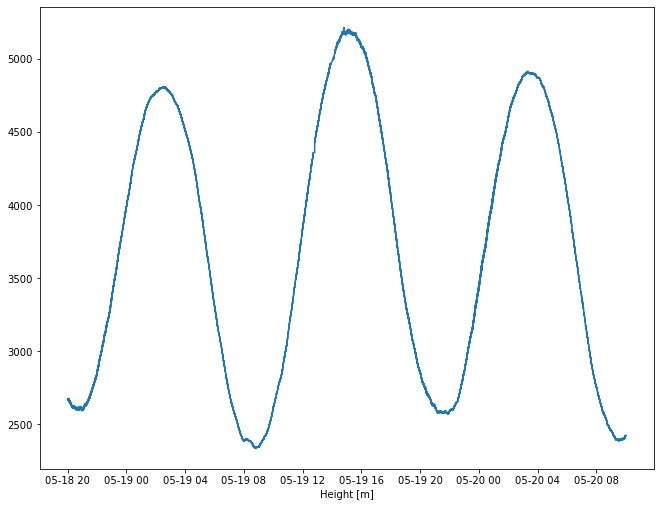

In [117]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(11.0,8.5))
ax  = fig.add_subplot(111)
ax.plot(TS,Y)
ax.set_xlabel(f"Timestamp")
ax.set_xlabel(f"Height [m]")



## Periodogram/Frequency Domain (FFT) Plot

Text(0.5, 1.0, 'Wide Band Periodogram')

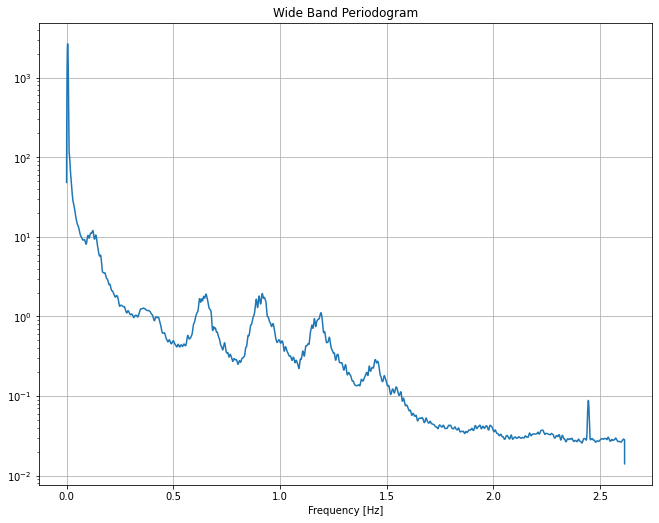

In [138]:
from scipy import signal
from matplotlib import pyplot as plt

N_PERSEG = 2**10
N_FFT = 2**16

fig = plt.figure(figsize=(11.0,8.5))
axes  = fig.subplots(nrows=1)
axes = [axes]  #comment out for more than 1 subplot

samples_per_second = samples_per_day/(60*60*24.0)
f_r, Pxx = signal.welch(Y-Y.mean(),fs=samples_per_second, nperseg=N_PERSEG, nfft=N_FFT)

axes[0].plot(f_r, Pxx)
YLIM = (1e-5,1e4)
axes[0].set_yscale('log')
#ax.set_xscale('log')

axes[0].grid(True)
axes[0].set_xlabel("Frequency [Hz]")
#axes[0].set_xlim(0.0,65.0)
#axes[0].set_ylim(*YLIM)
axes[0].set_title("Wide Band Periodogram")


#XLIM = (0.0,10000.0)
#YLIM = (1e-3,1e-1)

#axes[1].plot(f_r, Pxx)
#axes[1].set_xlim(*XLIM)
#axes[1].set_ylim(*YLIM)

#axes[1].set_yscale('log')
#axes[1].grid(True)
#axes[1].set_xlabel("Frequency [Hz]")
#axes[1].set_title("Low Freq. Band Periodogram")

 - For analysis relevant to tides, the frequency domain should probably be scaled in units "per day".  Unfortunately there is not yet enough data over the timescale of days to make a accurate frequency measurement using FFTs (or more likely I'm doing something wrong). Tidal frequencies are likely crammed into that peak right above 0.
 - These peaks scaled in the low Hz range might be relevant to waves!
 
`- CWV`